## Toxic Comment Classification

### EDA and Cleaning

In [1]:
#importing librarie
%matplotlib inline
import pandas as pd
import numpy as np
#warnings
import warnings
warnings.filterwarnings('ignore') #to ingnore the warnings in jupyter notebooks....
#visulaisation
import  seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#nlp
import nltk
from nltk.corpus import stopwords
import re  
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
#pickle & joblib&tqdm
import pickle
import joblib
from tqdm import tqdm
#sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import MLkNN

In [2]:
#importing train.csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train Data shape:",train.shape)
print("Test Data shape:",test.shape)

Train Data shape: (159571, 8)
Test Data shape: (153164, 2)


In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


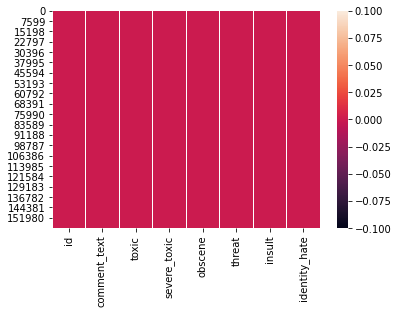

In [4]:
#visualising the null values
sns.heatmap(train.isnull())

In [4]:
# checking the sum of null values.
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
'''to describe the train data'''
word_count =train.comment_text.str.len()
word_count.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

In [7]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [21]:
count=[]
for label in tqdm(cols): 
    count.append(len(train[train[label]==1][label]))

100%|██████████| 6/6 [00:00<00:00, 149.58it/s]


In [22]:
'''to check the clean data that donot contain any toxic comment'''
train['clean']=train[cols].max(axis=1).apply(lambda x: 1 if x==0 else 0)
print(train['clean'].value_counts())

1    143346
0     16225
Name: clean, dtype: int64


In [23]:
'''to count the labels of the whole data'''
col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
data=[]
for label in tqdm(col): 
    data.append(len(train[train[label]==1][label]))

100%|██████████| 7/7 [00:00<00:00, 90.37it/s]


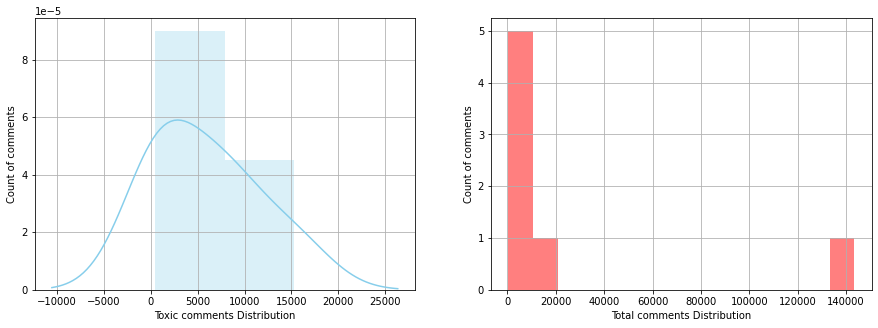

In [25]:
'''toxic comment distribution by removing the clean coments'''
plt.figure(figsize=(15, 5))
plt.subplot(121)
ax= sns.distplot(count,
                 kde=True,
                 color="skyblue",
                 hist_kws={"linewidth": 10,'alpha':0.3})
ax.set(xlabel='Toxic comments Distribution', ylabel='Count of comments')
plt.grid(True)
'''total comment distribution by removing the clean coments'''
plt.subplot(122)
ax= sns.distplot(data,
                 kde=False,
                 color="Red",
                 hist_kws={"linewidth": 5,'alpha':0.5})
ax.set(xlabel='Total comments Distribution', ylabel='Count of comments')
plt.grid(True)


In [26]:
y_train=train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [27]:
X_train = train[['id','comment_text']]
X_train.shape

(159571, 2)

In [28]:
X_test = test
X_test.shape

(153164, 2)

In [29]:
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


Mean length of comment before cleaning data: 394.073


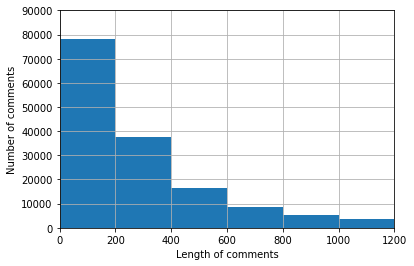

In [33]:
'''Average length decreaing while number of words/characters increasing...'''
comment=X_train['comment_text']
x = [len(comment[i]) for i in range(comment.shape[0])]
print('Mean length of comment before cleaning data: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

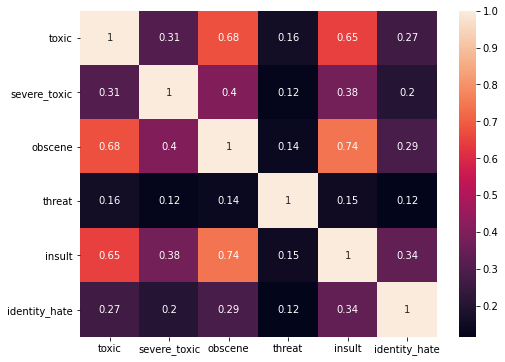

In [34]:
#correlation matrix heatmap
corr=y_train.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [35]:
x = y_train.sum(axis=1).value_counts()

In [37]:
'''to  check the comment having multi toxic comment'''
print("COMMENT counts having mutli labels:\n",x)

COMMENT counts having mutli labels:
 0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


In [39]:
#convert the dataframe to numpy.ndarray()
label = y_train.to_numpy()

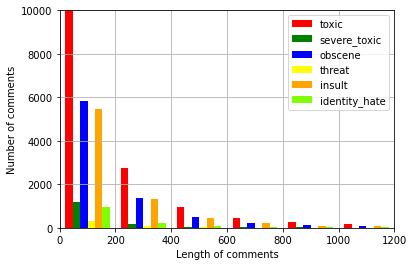

In [40]:
'''to check the class imbalacing and check the commemts length from here it can be judged that long comments are less toxic and compared to short'''
y = np.zeros(label.shape)
'''below loop calculates the count of the each label'''
for num in range(comment.shape[0]): #comment define in the above cells...
    l = len(comment[num])
    if label[num][0] :
        y[num][0] = l
    if label[num][1] :
        y[num][1] = l
    if label[num][2] :
        y[num][2] = l
    if label[num][3] :
        y[num][3] = l
    if label[num][4] :
        y[num][4] = l
    if label[num][5] :
        y[num][5] = l

labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 10000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

#### Word Clouds

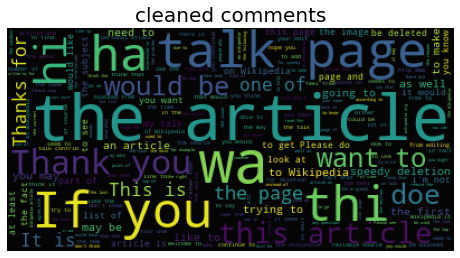

In [45]:
'''wordcloud visualisation to check the most common words in clean and toxic comments'''
#wordcloud for clean comments
stopword = set(stopwords.words("english"))
subset=train[train.clean==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(8,6))
plt.axis("off")
plt.title("cleaned comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

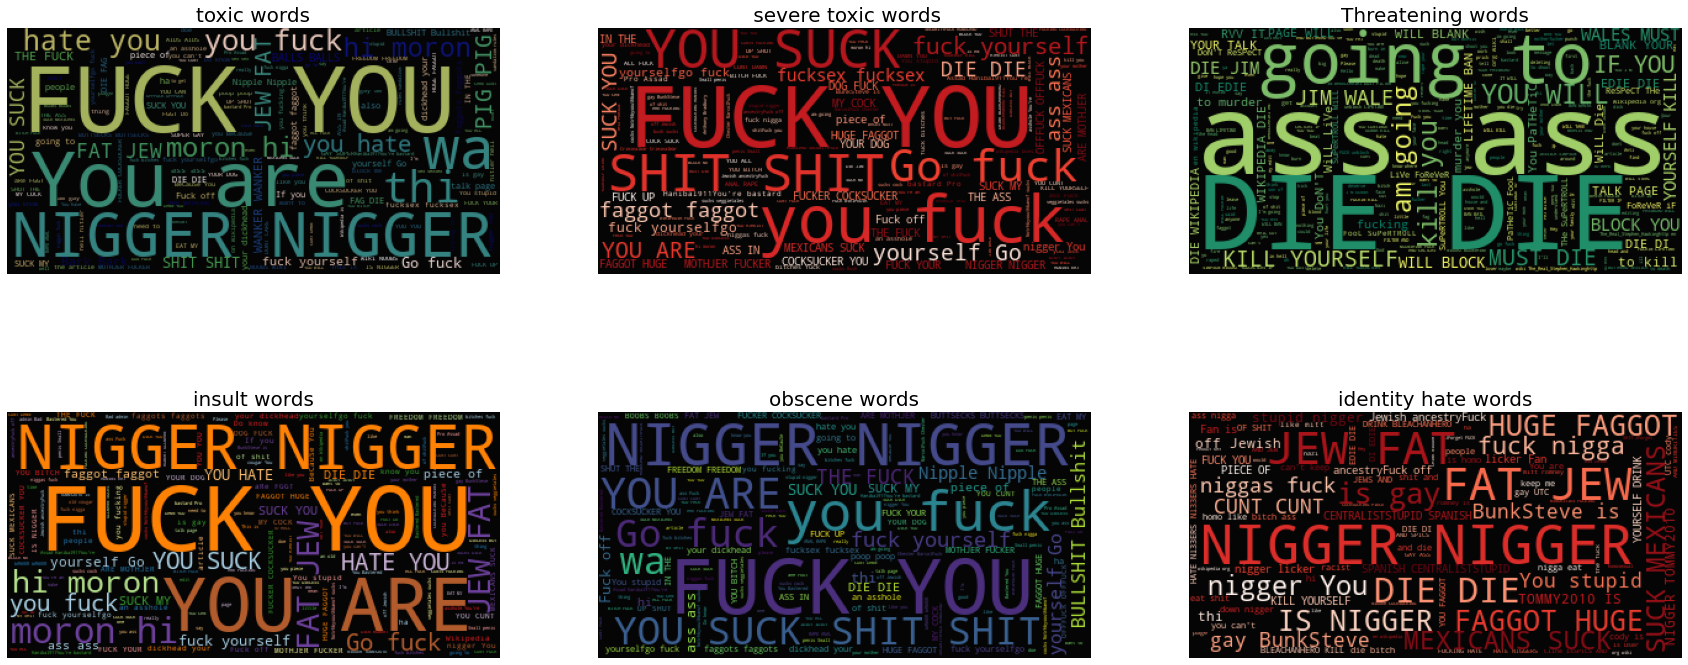

In [46]:
'''frequent words in toxic comments'''
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(30,20))
plt.subplot(331)
plt.axis("off")
plt.title("toxic words", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

'''frequent words in severe toxic comments'''
plt.subplot(332)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title(" severe toxic words", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds') ,alpha=0.98)

'''frequent words occuring in bullying comments'''
plt.subplot(333)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Threatening words", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer'), alpha=0.98)

'''frequent words occuring in insult comments'''
plt.subplot(334)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("insult words", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r'), alpha=0.98)


'''frequent words occuring in obscene comments'''
plt.subplot(335)
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("obscene words", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis'), alpha=0.98)

'''frequent words occuring in identity hate'''
plt.subplot(336)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.title("identity hate words", fontsize=20)
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Reds'), alpha=0.98)
plt.show()

### Text-Cleaning

In [47]:
'''text clening functions that replace short forms to full forms....'''
def decontracted(phrase):
# specific
    phrase = re.sub(r"won’t", "will not", phrase)
    phrase = re.sub(r"can’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [48]:
'''to remove the <.?/; and any numerical values from the text'''
def stripunc(X):
    return re.sub('[^A-Za-z]+',' ', str(X), flags=re.MULTILINE|re.DOTALL)

In [49]:
train_comm = X_train['comment_text'] #train_comm contains the comment column
test_comm = X_test['comment_text']

In [50]:
train_comm = train_comm.apply(decontracted) #cleaning functions are being applied on the text
train_comm = train_comm.apply(stripunc)

In [51]:
test_comm = test_comm.apply(decontracted) # cleaning functions applied on the test data
test_comm = test_comm.apply(stripunc)

In [52]:
train_comm = train_comm.apply(lambda x: x.strip()) # strip function has been used
test_comm = test_comm.apply(lambda x: x.strip())

In [53]:
train_comm

0         Explanation Why the edits made under my userna...
1         D aww He matches this background colour I am s...
2         Hey man I am really not trying to edit war It ...
3         More I ca not make any real suggestions on imp...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159566    And for the second time of asking when your vi...
159567    You should be ashamed of yourself That is a ho...
159568    Spitzer Umm theres no actual article for prost...
159569    And it looks like it was actually you who put ...
159570    And I really do not think you understand I cam...
Name: comment_text, Length: 159571, dtype: object

In [54]:
test_comm

0         Yo bitch Ja Rule is more succesful then you wi...
1                   From RfC The title is fine as it is IMO
2                            Sources Zawe Ashton on Lapland
3         If you have a look back at the source the info...
4                 I do not anonymously edit articles at all
                                ...                        
153159    i totally agree this stuff is nothing but too ...
153160    Throw from out field to home plate Does it get...
153161    Okinotorishima categories I see your changes a...
153162    One of the founding nations of the EU Germany ...
153163    Stop already Your bullshit is not welcome here...
Name: comment_text, Length: 153164, dtype: object

In [25]:
'''spacy lemmatizer not used due to its time consumption in lemmatizing the large corpus'''
# import spacy
# from nltk.tokenize import word_tokenize
# sp = spacy.load('en_core_web_sm')
# stop_rots = sp.Defaults.stop_words
# t.apply(lambda x: " ".join([word for word in x.split(" ") if not word in stop_rots]))
# from tqdm import tqdm
# tqdm(t.apply(lambda x: " ".join([word.lemma_ for word in sp(x)])))

In [55]:
stop_rods = set(stopwords.words('english'))
lm= WordNetLemmatizer()

In [56]:
'''removed not and nor because someone might have used he is not a bad guy or else...so to prevent that'''
stop_rods.remove('not')

In [57]:
'''applying the lemmatization on the text and test data.'''
train_com = train_comm.apply(lambda x: " ".join([lm.lemmatize(word,pos='v') for word in x.split(" ") if word not in stop_rods]))

In [58]:
test_com = test_comm.apply(lambda x: " ".join([lm.lemmatize(word,pos='v') for word in x.split(" ") if word not in stop_rods]))

In [59]:
X_train['comments'] = train_com

In [60]:
X_test['comments'] = test_com

In [61]:
'''X_train and X_test contains two columns id and cleaned(comments)'''
X_train = X_train[['id','comments']]
X_test = X_test[['id','comments']]

In [62]:
X_train.head()

,id,comments
0,0000997932d777bf,Explanation Why edit make username Hardcore Me...
1,000103f0d9cfb60f,D aww He match background colour I seemingly s...
2,000113f07ec002fd,Hey man I really not try edit war It guy const...
3,0001b41b1c6bb37e,More I ca not make real suggestions improvemen...
4,0001d958c54c6e35,You sir hero Any chance remember page


In [63]:
X_train['comments'].fillna("unknown", inplace=True)
X_test['comments'].fillna("unknown", inplace=True)

In [38]:
'''saving the cleaned dataframes to pickl files'''
# X_train.to_pickle('X_train.pkl')
# X_test.to_pickle('X_test.pkl')
# y_train.to_pickle('y_train.pkl')

In [192]:
'''loading the saved dataframes...'''
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')

In [46]:
'''not used .to_csv method because it contains nan values on again reading the files...'''
# X_train=pd.read_csv('train_final.csv')
# X_test = pd.read_csv('test_final.csv')
# y_train = pd.read_csv('final_labels.csv')